In [5]:
import os
import pandas as pd
from fastai.vision.all import *
from tqdm import tqdm
import subprocess
from fastcore.parallel import parallel
import shutil
import seaborn as sns

In [6]:
main_folder = '../../data/surgvu24/'

In [7]:
def count_surgical_cases(main_folder):
    dataset_folder = os.path.join(main_folder, 'dataset')
    # Count the number of subfolders in the dataset folder
    subfolders = [f for f in os.scandir(dataset_folder) if f.is_dir()]
    num_cases = len(subfolders)

    return num_cases
    

def get_video_duration_and_fps(file_path):
    try:
        container = av.open(file_path)
        duration = container.duration / av.time_base
        stream = container.streams.video[0]
        fps = stream.average_rate
        return duration, fps
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None, None

def get_videos_metadata(main_folder):
    dataset_folder = os.path.join(main_folder, 'dataset')
    data = []
    
    # Iterate through all subfolders in the main folder
    subfolders = [f.path for f in os.scandir(dataset_folder) if f.is_dir()]
    
    for subfolder in subfolders:
        # Use fastai's get_files to find .mp4 files
        mp4_files = get_files(subfolder, extensions='.mp4')
        
        for mp4_file in mp4_files:
            duration_seconds, fps = get_video_duration_and_fps(mp4_file)
            if duration_seconds is not None:
                data.append((mp4_file, duration_seconds, fps))
    
    # Create a DataFrame from the data
    df = pd.DataFrame(data, columns=['Filename', 'Duration', 'FPS'])
    return df

def format_duration(seconds):
    """Helper function to convert seconds to hours:minutes:seconds format"""
    hours, remainder = divmod(seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{int(hours)}:{int(minutes)}:{int(seconds)}"

def print_dataset_stats(main_folder):
    df = get_videos_metadata(main_folder)
    num_cases = count_surgical_cases(main_folder)
    
    # Total number of videos
    total_videos = len(df)
    
    # Total duration in seconds
    total_duration_seconds = df['Duration'].sum()
    
    # Convert total duration to hours:minutes:seconds format
    total_duration_formatted = format_duration(total_duration_seconds)
    
    # Find the longest and shortest video
    longest_video = df.loc[df['Duration'].idxmax()]
    shortest_video = df.loc[df['Duration'].idxmin()]
    
    # Format the duration of the longest and shortest videos
    longest_video_duration_formatted = format_duration(longest_video['Duration'])
    shortest_video_duration_formatted = format_duration(shortest_video['Duration'])
    
    # Get distinct FPS values
    distinct_fps = df['FPS'].unique()
    
    # Display the results
    print(f"Total number of cases: {num_cases}")
    print(f"Total number of videos: {total_videos}")
    print(f"Total duration: {total_duration_formatted}")
    print(f"Longest video: {Path(longest_video['Filename']).name} with duration {longest_video_duration_formatted}")
    print(f"Shortest video: {Path(shortest_video['Filename']).name} with duration {shortest_video_duration_formatted}")
    print(f"Frames per second in the dataset: {distinct_fps}")

    df.to_csv(f'{main_folder}videos_info.csv', index=False)

In [8]:
print_dataset_stats(main_folder)

Total number of cases: 155
Total number of videos: 280
Total duration: 837:47:18
Longest video: case_140_video_part_001.mp4 with duration 7:29:55
Shortest video: case_030_video_part_002.mp4 with duration 0:0:24
Frames per second in the dataset: [Fraction(60, 1)]


In [30]:
def get_keyframe_timestamps(video_path):
    """Extract the timestamps of keyframes using ffprobe."""
    command = [
        'ffprobe',
        '-loglevel', 'error',
        '-select_streams', 'v:0',  # Select the first video stream
        '-show_entries', 'frame=pkt_pts_time',  # Show presentation timestamps
        '-skip_frame', 'nokey',  # Skip non-keyframes
        '-of', 'csv=p=0',  # Output format as plain CSV
        str(video_path)
    ]
    
    # Execute the command and capture the output, suppressing stderr
    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL, text=True)
    timestamps = result.stdout.split()
    return timestamps

def extract_frames_at_timestamps(video_path, frames_folder, timestamps):
    """Extract frames at the given timestamps and store them in the frames folder."""
    for idx, timestamp in enumerate(timestamps):
        frame_name = f"{os.path.splitext(os.path.basename(video_path))[0]}_t{timestamp}_f{idx:06d}.jpg"
        output_file = os.path.join(frames_folder, frame_name)
        command = [
            'ffmpeg', '-ss', timestamp, '-i', video_path, '-vframes', '1', output_file,
            '-hide_banner', '-loglevel', 'error'
        ]
        subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

def process_case_folder(case_folder, frames_folder):
    """Process all videos in a case folder and extract frames at keyframes."""
    video_files = [f for f in os.listdir(case_folder) if f.endswith('.mp4')]

    for video_file in video_files:
        video_path = os.path.join(case_folder, video_file)
        timestamps = get_keyframe_timestamps(video_path)
        extract_frames_at_timestamps(video_path, frames_folder, timestamps)

    return len(video_files)

def process_case_folder_wrapper(args):
    return process_case_folder(*args)

def split_videos(main_folder):
    frames_folder = os.path.join(main_folder, 'frames')
    os.makedirs(frames_folder, exist_ok=True)
    
    dataset_folder = os.path.join(main_folder, 'dataset')
    
    # Iterate through all subfolders in the dataset folder
    subfolders = [f.path for f in os.scandir(dataset_folder) if f.is_dir()]

    total_videos = sum(len([f for f in os.listdir(subfolder) if f.endswith('.mp4')]) for subfolder in subfolders)
    
    with tqdm(total=total_videos, desc="Processing videos") as pbar:
        # Prepare arguments for parallel processing
        args_list = [(subfolder, frames_folder) for subfolder in subfolders]
        
        # Use Fastcore's parallel to process case folders in parallel
        results = parallel(process_case_folder_wrapper, args_list, n_workers=os.cpu_count())

        # Update the progress bar manually
        for result in results:
            pbar.update(result)

# Run the function using the existing main_folder variable
split_videos(main_folder)

Processing videos: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [2:05:42<00:00, 26.94s/it]


In [70]:
def extract_frames_metadata(main_folder):
    frames_folder = os.path.join(main_folder, 'frames')
    surgvu_folder = main_folder
    
    # List to store the filename and timestamp data
    frames_data = []

    # Get all jpg files in the frames folder
    frame_files = get_image_files(frames_folder)

    # Iterate through all frame files
    for frame_file in frame_files:
        frame_file = str(frame_file)
        # Extract details from the filename
        frame_name = os.path.splitext(os.path.basename(frame_file))[0]
        parts = frame_name.split('_t')
        if len(parts) > 1:
            video_part = parts[0]
            timestamp_part = parts[1].split('_f')[0]
            frame_index = parts[1].split('_f')[1]
            case_folder = video_part.split('_video_part_')[0]
            video_name = f"{video_part}.mp4"
            frames_data.append([case_folder, video_name, frame_name, timestamp_part, frame_index])

    # Create a DataFrame from the data
    frames_df = pd.DataFrame(frames_data, columns=['case_folder', 'video_name', 'filename', 'timestamp', 'frame_index'])

    # Convert timestamp and frame_index to numeric for sorting
    frames_df['timestamp'] = pd.to_numeric(frames_df['timestamp'])
    frames_df['frame_index'] = pd.to_numeric(frames_df['frame_index'])

    # Sort the DataFrame by video_name, and frame_index
    frames_df = frames_df.sort_values(by=['video_name', 'frame_index']).reset_index(drop=True)

    # Drop the frame_index column
    frames_df = frames_df.drop(columns=['frame_index'])

    # Save the DataFrame to CSV in the surgvu folder
    output_csv = os.path.join(surgvu_folder, 'frames_info.csv')
    frames_df.to_csv(output_csv, index=False)
    print(f"Frames metadata saved to {output_csv}")

# Usage example
extract_frames_metadata(main_folder)

Frames metadata saved to ../../data/surgvu24/frames_info.csv


In [51]:
def copy_label_files(source_root, destination_root, file_names):
    """
    Copies specified CSV files from source_root to destination_root, maintaining the directory structure.
    
    Args:
    source_root (str): Path to the source root directory.
    destination_root (str): Path to the destination root directory.
    file_names (list): List of file names to copy.
    """
    for root, dirs, files in os.walk(source_root):
        for file_name in file_names:
            if file_name in files:
                relative_path = os.path.relpath(root, source_root)
                destination_dir = os.path.join(destination_root, relative_path)
                os.makedirs(destination_dir, exist_ok=True)
                shutil.copy2(os.path.join(root, file_name), os.path.join(destination_dir, file_name))
                print(f"Copied {file_name} from {root} to {destination_dir}")

# Define source and destination directories
source_root = os.path.join(main_folder, 'labels')
destination_root = os.path.join(main_folder, 'dataset')
file_names = ['tasks.csv', 'tools.csv']

# Copy the files
copy_label_files(source_root, destination_root, file_names)

Copied tasks.csv from ../../data/surgvu24/labels/case_063 to ../../data/surgvu24/dataset/case_063
Copied tools.csv from ../../data/surgvu24/labels/case_063 to ../../data/surgvu24/dataset/case_063
Copied tasks.csv from ../../data/surgvu24/labels/case_073 to ../../data/surgvu24/dataset/case_073
Copied tools.csv from ../../data/surgvu24/labels/case_073 to ../../data/surgvu24/dataset/case_073
Copied tasks.csv from ../../data/surgvu24/labels/case_097 to ../../data/surgvu24/dataset/case_097
Copied tools.csv from ../../data/surgvu24/labels/case_097 to ../../data/surgvu24/dataset/case_097
Copied tasks.csv from ../../data/surgvu24/labels/case_047 to ../../data/surgvu24/dataset/case_047
Copied tools.csv from ../../data/surgvu24/labels/case_047 to ../../data/surgvu24/dataset/case_047
Copied tasks.csv from ../../data/surgvu24/labels/case_008 to ../../data/surgvu24/dataset/case_008
Copied tools.csv from ../../data/surgvu24/labels/case_008 to ../../data/surgvu24/dataset/case_008
Copied tasks.csv fro

In [71]:
def preprocess_tasks_csv(tasks_csv_path):
    tasks_df = pd.read_csv(tasks_csv_path)
    
    # Duplicate rows where start_part and stop_part are not the same
    multi_part_tasks = tasks_df[tasks_df['start_part'] != tasks_df['stop_part']].copy()
    
    # Adjust the original rows
    condition = tasks_df['start_part'] != tasks_df['stop_part']
    tasks_df.loc[condition, 'stop_part'] = tasks_df.loc[condition, 'start_part']
    tasks_df.loc[condition, 'stop_time'] = -1
    
    # Adjust the duplicated rows
    multi_part_tasks['start_part'] = multi_part_tasks['stop_part']
    multi_part_tasks['start_time'] = 0
    
    # Concatenate the modified DataFrames
    tasks_df = pd.concat([tasks_df, multi_part_tasks], ignore_index=True)
    
    return tasks_df

In [81]:
tasks_csv_path = os.path.join(main_folder, 'dataset', 'case_043', 'tasks.csv')
frames_df = pd.read_csv(tasks_csv_path)
frames_df

,index,start_part,start_time,stop_part,stop_time,groundtruth_taskname
0,0,1,63.020604,1,173.645004,Suturing
1,1,1,3683.859004,1,3767.309004,Retraction and collision avoidance
2,2,1,5323.139004,1,6124.429004,Suturing
3,3,1,9782.939004,1,10542.389004,Uterine horn
4,4,1,11235.989004,1,11700.089004,Suturing
5,5,1,12189.989004,1,13268.389004,Suspensory ligaments
6,6,1,14268.189004,1,14986.689004,Suturing
7,7,1,15711.289004,1,16498.189004,Rectal artery/vein
8,8,1,17207.322337,2,1047.149004,Suturing
9,9,2,4.244144,2,1054.259004,Suturing


In [82]:
frames_df=preprocess_tasks_csv(tasks_csv_path)
frames_df

,index,start_part,start_time,stop_part,stop_time,groundtruth_taskname
0,0,1,63.020604,1,173.645004,Suturing
1,1,1,3683.859004,1,3767.309004,Retraction and collision avoidance
2,2,1,5323.139004,1,6124.429004,Suturing
3,3,1,9782.939004,1,10542.389004,Uterine horn
4,4,1,11235.989004,1,11700.089004,Suturing
5,5,1,12189.989004,1,13268.389004,Suspensory ligaments
6,6,1,14268.189004,1,14986.689004,Suturing
7,7,1,15711.289004,1,16498.189004,Rectal artery/vein
8,8,1,17207.322337,1,-1.000000,Suturing
9,9,2,4.244144,2,1054.259004,Suturing


In [83]:
part_str = 'case_000_video_part_002.mp4'.split('_video_part_')[1].split('.')[0]
part_num = int(part_str)
timestamp = float(6.4)
part_str, part_num, timestamp

('002', 2, 6.4)

In [88]:
matching_tasks = frames_df.query(
                    f"start_part <= {part_num} and stop_part >= {part_num} and start_time <= {timestamp} and (stop_time >= {timestamp} or stop_time == -1)"
                )
print(matching_tasks)
if not matching_tasks.empty:
    unique_labels = matching_tasks['groundtruth_taskname'].unique()
for label in unique_labels:
    print(label)


    index  start_part  start_time  stop_part    stop_time groundtruth_taskname
9       9           2    4.244144          2  1054.259004             Suturing
10      8           2    0.000000          2  1047.149004             Suturing
Suturing


In [89]:
def extract_frame_labels(main_folder):
    frames_folder = os.path.join(main_folder, 'frames')
    frames_csv_path = os.path.join(main_folder, 'frames_info.csv')
    frames_df = pd.read_csv(frames_csv_path)

    # Add a new column for the labels
    frames_df['task_label'] = None

    for case_folder in tqdm(frames_df['case_folder'].unique(), desc='Processing case folders'):
        tasks_csv_path = os.path.join(main_folder, 'dataset', case_folder, 'tasks.csv')
        if os.path.exists(tasks_csv_path):
            tasks_df = preprocess_tasks_csv(tasks_csv_path)
            
            for idx, row in frames_df[frames_df['case_folder'] == case_folder].iterrows():
                part_str = row['video_name'].split('_video_part_')[1].split('.')[0]
                part_num = int(part_str)
                timestamp = float(row['timestamp'])
                
                matching_tasks = tasks_df.query(
                    f"start_part <= {part_num} and stop_part >= {part_num} and start_time <= {timestamp} and (stop_time >= {timestamp} or stop_time == -1)")
                
                if not matching_tasks.empty:
                    unique_labels = matching_tasks['groundtruth_taskname'].unique()
                    unique_labels_sorted = sorted(unique_labels)  # Sort labels
                    unique_labels_str = [str(label) for label in unique_labels_sorted]  # Convert all labels to strings
                    frames_df.at[idx, 'task_label'] = ','.join(unique_labels_str)

    # Save the updated DataFrame to CSV
    frames_csv_path = os.path.join(main_folder, 'frames_info.csv')
    frames_df.to_csv(frames_csv_path, index=False)
    print(f"Frames metadata with labels saved to {frames_csv_path}")

# Usage example
extract_frame_labels(main_folder)

Processing case folders: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [19:43<00:00,  7.63s/it]


Frames metadata with labels saved to ../../data/surgvu24/frames_info.csv


In [90]:
def compute_null_non_null_labels(frames_df):
    # Count the number of null and non-null labels
    null_labels = frames_df['task_label'].isnull().sum()
    non_null_labels = frames_df['task_label'].notnull().sum()
    
    # Calculate percentages
    total_labels = len(frames_df)
    null_percentage = (null_labels / total_labels) * 100
    non_null_percentage = (non_null_labels / total_labels) * 100

    
    print(f"Number of null labels: {null_labels} ({null_percentage:.2f}%)")
    print(f"Number of non-null labels: {non_null_labels} ({non_null_percentage:.2f}%)")

# Example usage
frames_csv_path = os.path.join(main_folder, 'frames_info.csv')
frames_df = pd.read_csv(frames_csv_path)
compute_null_non_null_labels(frames_df)

Number of null labels: 548357 (75.37%)
Number of non-null labels: 179233 (24.63%)


In [9]:
def display_label_counts(frames_df):
    # Get counts of unique label values, including nulls
    label_counts = frames_df['task_label'].value_counts(dropna=False)
    
    print("Label counts:")
    print(label_counts)

# Example usage
frames_csv_path = os.path.join(main_folder, 'frames_info.csv')
frames_df = pd.read_csv(frames_csv_path)
display_label_counts(frames_df)

Label counts:
task_label
Other/Unannotated                     100000
Suturing                               64961
Uterine horn                           37785
Rectal artery/vein                     32401
Suspensory ligaments                   20898
Skills application                     13362
Retraction and collision avoidance      5083
Range of motion                         4685
Name: count, dtype: int64


In [93]:
# Filter rows where task_label contains a comma
rows_with_comma = frames_df[frames_df['task_label'].str.contains(',', na=False)]

# Display the filtered rows
rows_with_comma

,case_folder,video_name,filename,timestamp,task_label
227922,case_049,case_049_video_part_002.mp4,case_049_video_part_002_t368.200000_f000089,368.200000,"Rectal artery/vein,Skills application"
227923,case_049,case_049_video_part_002.mp4,case_049_video_part_002_t372.366667_f000090,372.366667,"Rectal artery/vein,Skills application"
227924,case_049,case_049_video_part_002.mp4,case_049_video_part_002_t376.533333_f000091,376.533333,"Rectal artery/vein,Skills application"
227925,case_049,case_049_video_part_002.mp4,case_049_video_part_002_t380.700000_f000092,380.700000,"Rectal artery/vein,Skills application"
227926,case_049,case_049_video_part_002.mp4,case_049_video_part_002_t384.866667_f000093,384.866667,"Rectal artery/vein,Skills application"
227927,case_049,case_049_video_part_002.mp4,case_049_video_part_002_t389.033333_f000094,389.033333,"Rectal artery/vein,Skills application"
227928,case_049,case_049_video_part_002.mp4,case_049_video_part_002_t393.200000_f000095,393.200000,"Rectal artery/vein,Skills application"
227929,case_049,case_049_video_part_002.mp4,case_049_video_part_002_t397.366667_f000096,397.366667,"Rectal artery/vein,Skills application"
227930,case_049,case_049_video_part_002.mp4,case_049_video_part_002_t401.533333_f000097,401.533333,"Rectal artery/vein,Skills application"
227931,case_049,case_049_video_part_002.mp4,case_049_video_part_002_t405.700000_f000098,405.700000,"Rectal artery/vein,Skills application"


In [10]:
# Load the frames_info.csv file
frames_csv_path = os.path.join(main_folder, 'frames_info.csv')
frames_df = pd.read_csv(frames_csv_path)

# Filter rows where task_label is null
null_label_rows = frames_df[frames_df['task_label'].isnull()]

# If there are more than 100k null label rows, randomly sample 100k rows
if len(null_label_rows) > 100000:
    sampled_null_label_rows = null_label_rows.sample(n=100000, random_state=42)
else:
    sampled_null_label_rows = null_label_rows

# Get the indices of the rows to keep
indices_to_keep = sampled_null_label_rows.index

# Drop rows where task_label is null but not in the sampled rows
frames_df = frames_df.drop(null_label_rows.index.difference(indices_to_keep))

# Assign 'Other/Unannotated' to the remaining null task_label rows
frames_df.loc[frames_df['task_label'].isnull(), 'task_label'] = 'Other/Unannotated'


In [11]:
display_label_counts(frames_df)

Label counts:
task_label
Other/Unannotated                     100000
Suturing                               64961
Uterine horn                           37785
Rectal artery/vein                     32401
Suspensory ligaments                   20898
Skills application                     13362
Retraction and collision avoidance      5083
Range of motion                         4685
Name: count, dtype: int64


In [12]:
# Filter out rows with 'Rectal artery/vein' and 'Skills application' labels
labels_to_remove = ['Rectal artery/vein,Skills application']
frames_df = frames_df[~frames_df['task_label'].isin(labels_to_remove)]

In [13]:
display_label_counts(frames_df)

Label counts:
task_label
Other/Unannotated                     100000
Suturing                               64961
Uterine horn                           37785
Rectal artery/vein                     32401
Suspensory ligaments                   20898
Skills application                     13362
Retraction and collision avoidance      5083
Range of motion                         4685
Name: count, dtype: int64


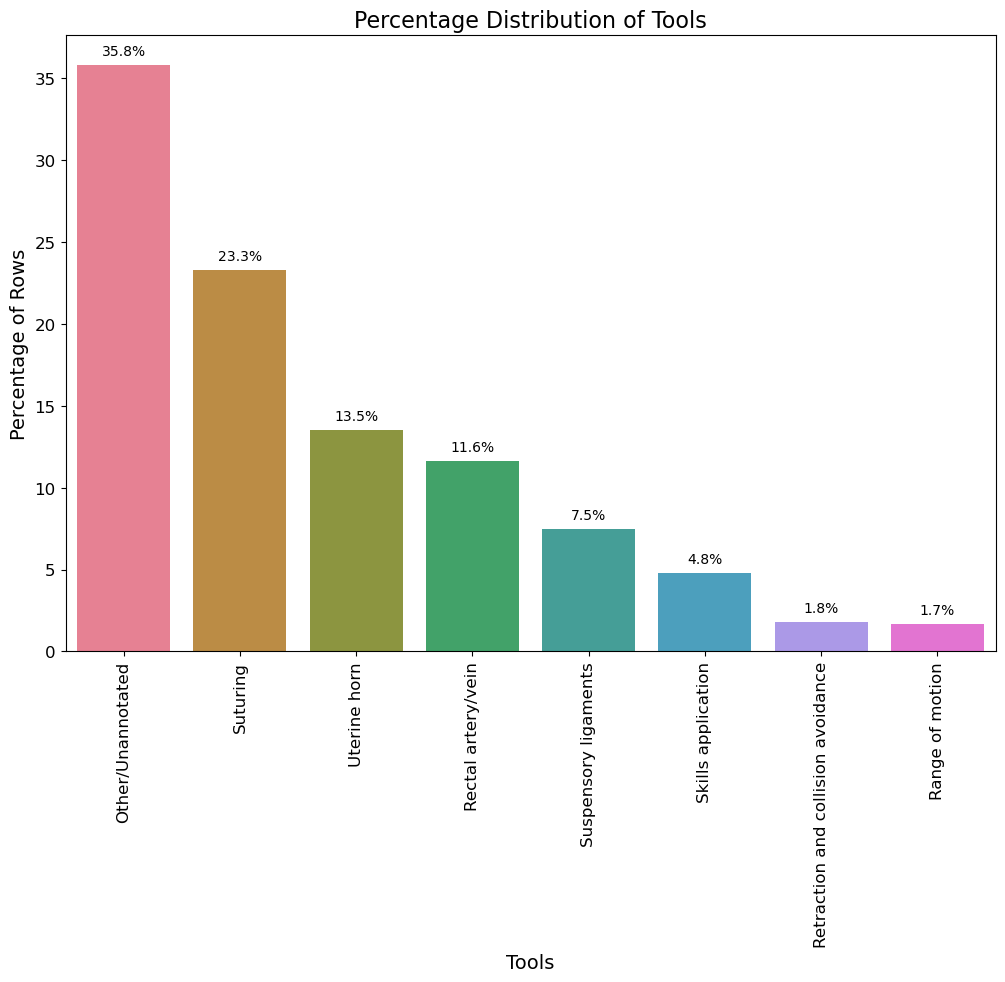

In [112]:
# Count the occurrences of each label
label_counts = frames_df['task_label'].value_counts()

# Convert counts to percentages
label_percentages = (label_counts / label_counts.sum()) * 100

# Create a bar plot
plt.figure(figsize=(12, 8))
colors = sns.color_palette("husl", len(label_percentages))  # Different colors for each bar

bar_plot = sns.barplot(x=label_percentages.index, y=label_percentages.values, palette=colors, hue=label_percentages.index, dodge=False, legend=False)
bar_plot.bar_width = 0.1

# Add percentage labels at the top of each bar
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height():.1f}%', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='center', 
                      xytext=(0, 10), 
                      textcoords='offset points')

plt.xlabel('Tools', fontsize=14)
plt.ylabel('Percentage of Rows', fontsize=14)
plt.title('Percentage Distribution of Tools', fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

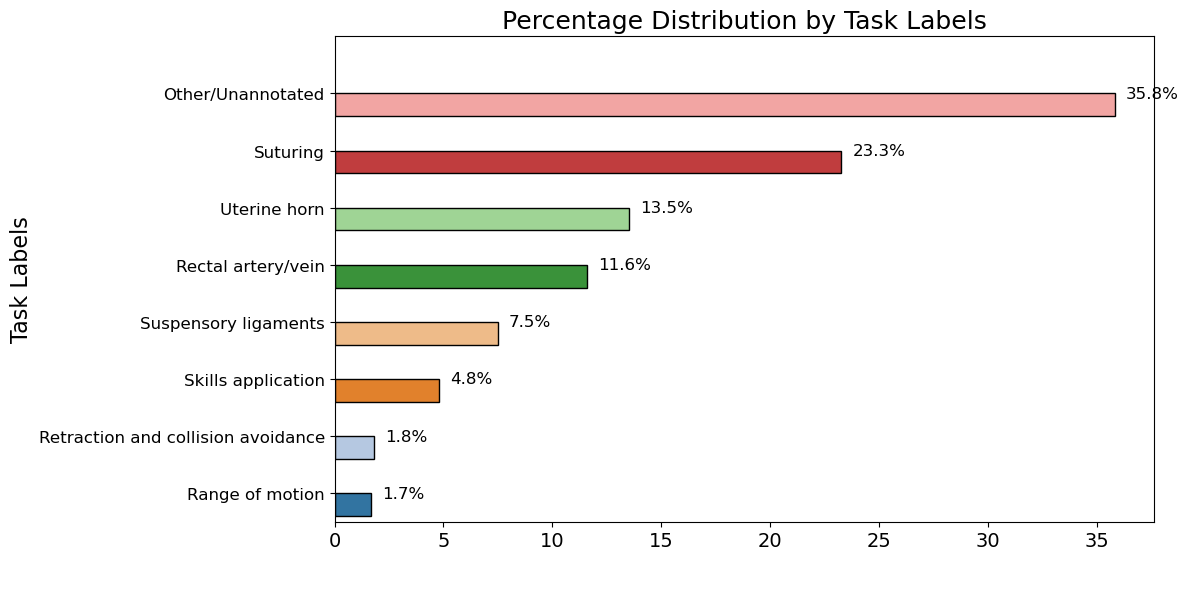

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming frames_df is already defined and contains the 'task_label' column
# If not, please load your data into frames_df

# Count the occurrences of each label
label_counts = frames_df['task_label'].value_counts()

# Convert counts to percentages
label_percentages = (label_counts / label_counts.sum()) * 100

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Task Label': label_percentages.index,
    'Percentage': label_percentages.values
})

# Sort the DataFrame for better visual appeal (optional)
plot_df = plot_df.sort_values(by='Percentage', ascending=True)
plot_df.reset_index(drop=True, inplace=True)

# Set the desired bar height and calculate total height needed
new_height = 0.4  # Adjust as needed; smaller value means thinner bars
num_bars = len(plot_df)
total_bar_height = num_bars * new_height

# Create a horizontal bar plot without specifying 'height'
fig_height = max(6, total_bar_height + 2)  # Add padding
plt.figure(figsize=(12, fig_height))  # Adjusted height based on number of bars
colors = sns.color_palette("tab20", num_bars)  # Vivid and distinguishable colors

# Create the bar plot
bar_plot = sns.barplot(
    x='Percentage',
    y='Task Label',
    data=plot_df,
    palette=colors,
    hue='Task Label',       # Assign 'Task Label' to 'hue'
    dodge=False,
    edgecolor='black',
    linewidth=1,
    legend=False            # Suppress the legend
)

# Remove the FutureWarning by assigning 'hue' and setting 'legend=False'

# Adjust the height of the bars
for bar in bar_plot.patches:
    bar.set_height(new_height)

# Adjust y-axis positions to reduce space between bars
bar_plot.set_ylim(-0.5, num_bars - 0.5)

# Add percentage labels at the end of each bar
for index, (value, label) in enumerate(zip(plot_df['Percentage'], plot_df['Task Label'])):
    plt.text(
        value + 0.5,        # Slightly offset to the right
        index,              # y-coordinate
        f'{value:.1f}%',
        va='center',
        fontsize=12
    )

# Enhance font sizes
plt.xlabel(' ', fontsize=16)
plt.ylabel('Task Labels', fontsize=16)
plt.title('Percentage Distribution by Task Labels', fontsize=18)

# Increase tick label sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

# Adjust y-axis limits to fit all bars and labels
bar_plot.set_ylim(-0.5, num_bars - 0.4 + new_height)

# Remove excessive whitespace by adjusting the margins
plt.subplots_adjust(left=0.3, right=0.95, top=0.95, bottom=0.05)

# Adjust layout to fit labels
plt.tight_layout()

# Save the figure in high resolution
plt.savefig('task_label_distribution.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [113]:
# Add a new column for the train/valid split
frames_df['valid'] = False

# Get unique cases
unique_cases = frames_df['case_folder'].unique()
np.random.shuffle(unique_cases)

# Split cases into train and valid sets (80:20)
split_index = int(len(unique_cases) * 0.8)
train_cases = unique_cases[:split_index]
valid_cases = unique_cases[split_index:]

# Assign the valid column based on the case it belongs to
frames_df.loc[frames_df['case_folder'].isin(valid_cases), 'valid'] = True

# Check the distribution of task labels in train and valid sets
train_distribution = frames_df[frames_df['valid'] == False]['task_label'].value_counts(normalize=True) * 100
valid_distribution = frames_df[frames_df['valid'] == True]['task_label'].value_counts(normalize=True) * 100

print("Train set distribution:\n", train_distribution)
print("\nValid set distribution:\n", valid_distribution)


Train set distribution:
 task_label
Other/Unannotated                     36.141875
Suturing                              23.003752
Uterine horn                          13.230792
Rectal artery/vein                    11.855745
Suspensory ligaments                   7.557532
Skills application                     4.679792
Retraction and collision avoidance     1.796146
Range of motion                        1.734367
Name: proportion, dtype: float64

Valid set distribution:
 task_label
Other/Unannotated                     34.618968
Suturing                              24.257669
Uterine horn                          14.667073
Rectal artery/vein                    10.674662
Suspensory ligaments                   7.217508
Skills application                     5.183190
Retraction and collision avoidance     1.912360
Range of motion                        1.468571
Name: proportion, dtype: float64


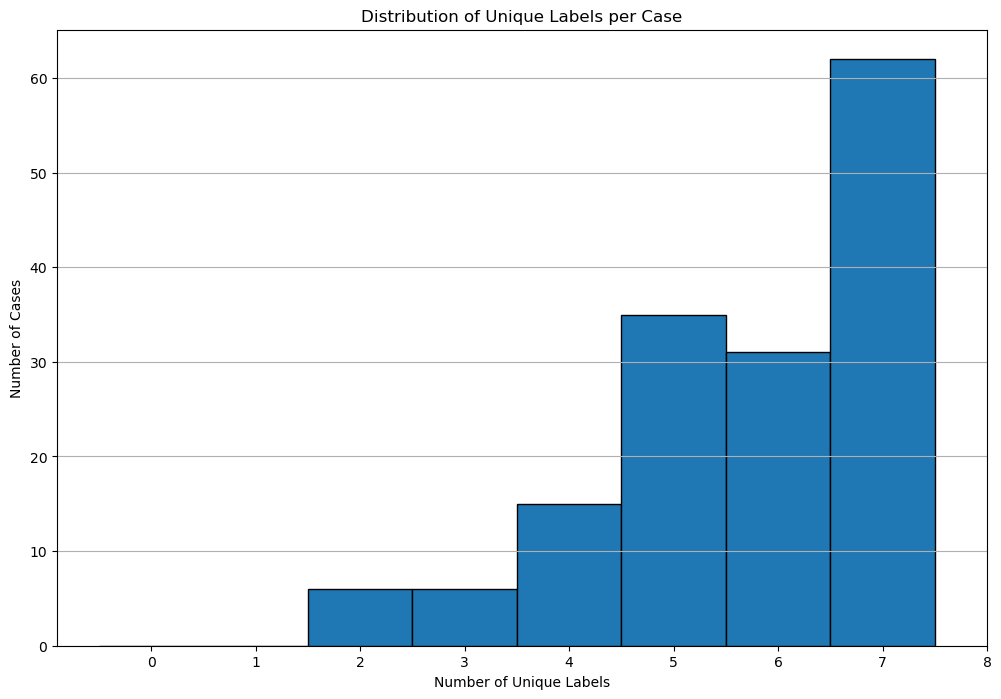

In [114]:


# Calculate the number of unique labels per case
unique_labels_per_case = frames_df.groupby('case_folder')['task_label'].nunique()

# Plot the distribution
plt.figure(figsize=(12, 8))
plt.hist(unique_labels_per_case, bins=range(unique_labels_per_case.max() + 1), edgecolor='black', align='left')
plt.xlabel('Number of Unique Labels')
plt.ylabel('Number of Cases')
plt.title('Distribution of Unique Labels per Case')
plt.xticks(range(unique_labels_per_case.max() + 1))  # Show all x-axis values from 0 to max unique labels
plt.grid(axis='y')
plt.show()

In [115]:
# Calculate the number of unique labels per case
unique_labels_per_case = frames_df.groupby('case_folder')['task_label'].nunique()

# Add the unique labels count to frames_df
frames_df = frames_df.merge(unique_labels_per_case.rename('unique_labels_count'), on='case_folder')

# Create a new column 'valid' and initialize with False
frames_df['valid'] = False

# Split the data into train and validation sets
for labels_count in unique_labels_per_case.unique():
    cases_with_labels = frames_df[frames_df['unique_labels_count'] == labels_count]['case_folder'].unique()
    np.random.shuffle(cases_with_labels)
    split_idx = int(len(cases_with_labels) * 0.8)
    train_cases = cases_with_labels[:split_idx]
    valid_cases = cases_with_labels[split_idx:]
    
    frames_df.loc[frames_df['case_folder'].isin(valid_cases), 'valid'] = True

In [116]:
frames_df

,case_folder,video_name,filename,timestamp,task_label,valid,unique_labels_count
0,case_000,case_000_video_part_001.mp4,case_000_video_part_001_t8.333333_f000002,8.333333,Other/Unannotated,False,2
1,case_000,case_000_video_part_001.mp4,case_000_video_part_001_t25.000000_f000006,25.000000,Other/Unannotated,False,2
2,case_000,case_000_video_part_001.mp4,case_000_video_part_001_t29.166667_f000007,29.166667,Other/Unannotated,False,2
3,case_000,case_000_video_part_001.mp4,case_000_video_part_001_t99.416667_f000024,99.416667,Other/Unannotated,False,2
4,case_000,case_000_video_part_001.mp4,case_000_video_part_001_t124.416667_f000030,124.416667,Other/Unannotated,False,2
...,...,...,...,...,...,...,...
279170,case_154,case_154_video_part_002.mp4,case_154_video_part_002_t1888.833333_f000457,1888.833333,Other/Unannotated,False,7
279171,case_154,case_154_video_part_002.mp4,case_154_video_part_002_t1926.333333_f000466,1926.333333,Other/Unannotated,False,7
279172,case_154,case_154_video_part_002.mp4,case_154_video_part_002_t1930.500000_f000467,1930.500000,Other/Unannotated,False,7
279173,case_154,case_154_video_part_002.mp4,case_154_video_part_002_t1943.000000_f000470,1943.000000,Other/Unannotated,False,7


In [119]:
# Calculate the distribution of labels by valid values
label_distribution = frames_df.groupby(['task_label', 'valid']).size().unstack(fill_value=0)

# Calculate the percentages
label_distribution['num_train'] = label_distribution[False]
label_distribution['num_valid'] = label_distribution[True]
label_distribution['%_train'] = (label_distribution['num_train'] / (label_distribution['num_train'] + label_distribution['num_valid'])) * 100
label_distribution['%_valid'] = (label_distribution['num_valid'] / (label_distribution['num_train'] + label_distribution['num_valid'])) * 100

# Display the table
label_distribution = label_distribution[['num_train', 'num_valid', '%_train', '%_valid']]
label_distribution.reset_index(inplace=True)

label_distribution

valid,task_label,num_train,num_valid,%_train,%_valid
0,Other/Unannotated,77259,22741,77.259000,22.741000
1,Range of motion,3633,1052,77.545358,22.454642
2,Rectal artery/vein,26742,5659,82.534490,17.465510
3,Retraction and collision avoidance,4053,1030,79.736376,20.263624
4,Skills application,10115,3247,75.699746,24.300254
5,Suspensory ligaments,15592,5306,74.610011,25.389989
6,Suturing,51657,13304,79.520020,20.479980
7,Uterine horn,29841,7944,78.975784,21.024216


In [121]:
# Calculate the distribution of unique label counts by valid values
unique_label_distribution = frames_df.groupby(['unique_labels_count', 'valid']).size().unstack(fill_value=0)

# Calculate the number of rows for each unique label count in both train and validation sets
unique_label_distribution['num_train'] = unique_label_distribution[False]
unique_label_distribution['num_valid'] = unique_label_distribution[True]

# Calculate the percentages
unique_label_distribution['%_train'] = (unique_label_distribution['num_train'] / (unique_label_distribution['num_train'] + unique_label_distribution['num_valid'])) * 100
unique_label_distribution['%_valid'] = (unique_label_distribution['num_valid'] / (unique_label_distribution['num_train'] + unique_label_distribution['num_valid'])) * 100

# Reorder the columns
unique_label_distribution = unique_label_distribution[['num_train', 'num_valid', '%_train', '%_valid']]

# Reset index to get a clean table format
unique_label_distribution.reset_index(inplace=True)

# Display the table
unique_label_distribution

valid,unique_labels_count,num_train,num_valid,%_train,%_valid
0,2,1595,2159,42.488013,57.511987
1,3,3354,1721,66.088670,33.911330
2,4,14199,3373,80.804689,19.195311
3,5,47705,11767,80.214218,19.785782
4,6,46634,13172,77.975454,22.024546
5,7,66876,17561,79.202245,20.797755
6,8,38529,10530,78.536048,21.463952


In [120]:
# Save the updated DataFrame to CSV
frames_csv_path = os.path.join(main_folder, 'frames_info.csv')
frames_df.to_csv(frames_csv_path, index=False)
print(f"Frames metadata with train/valid split saved to {frames_csv_path}")

Frames metadata with train/valid split saved to ../../data/surgvu24/frames_info.csv


In [3]:
import os
import pandas as pd

def get_distinct_task_names(dataroot_path):
    dataset_folder = os.path.join(dataroot_path, 'dataset')
    distinct_tasks = set()
    files_with_issues = []

    # Traverse through all case subfolders
    for case_folder in os.listdir(dataset_folder):
        case_path = os.path.join(dataset_folder, case_folder)
        if os.path.isdir(case_path):
            tasks_csv_path = os.path.join(case_path, 'tasks.csv')
            if os.path.exists(tasks_csv_path):
                tasks_df = pd.read_csv(tasks_csv_path)
                # Check for non-string values
                for task in tasks_df['groundtruth_taskname'].unique():
                    if isinstance(task, str):
                        distinct_tasks.add(task)
                    else:
                        files_with_issues.append(tasks_csv_path)

    # Print the distinct task names
    print("Distinct Task Names:")
    for task in sorted(distinct_tasks):
        print(task)
    
    # Print files with non-string task names
    if files_with_issues:
        print("\nFiles with non-string values in 'groundtruth_taskname':")
        for file in set(files_with_issues):  # Use set to avoid duplicates
            print(file)
    else:
        print("\nNo files with non-string values found.")

# Usage example
dataroot_path = '/home/exsdatalab/data/surgvu24'
get_distinct_task_names(dataroot_path)

Distinct Task Names:
Range of motion
Rectal artery/vein
Retraction and collision avoidance
Skills application
Suspensory ligaments
Suturing
Uterine horn

Files with non-string values in 'groundtruth_taskname':
/home/exsdatalab/data/surgvu24/dataset/case_093/tasks.csv
/home/exsdatalab/data/surgvu24/dataset/case_140/tasks.csv
/home/exsdatalab/data/surgvu24/dataset/case_033/tasks.csv
/home/exsdatalab/data/surgvu24/dataset/case_021/tasks.csv
/home/exsdatalab/data/surgvu24/dataset/case_024/tasks.csv
/home/exsdatalab/data/surgvu24/dataset/case_153/tasks.csv
/home/exsdatalab/data/surgvu24/dataset/case_074/tasks.csv


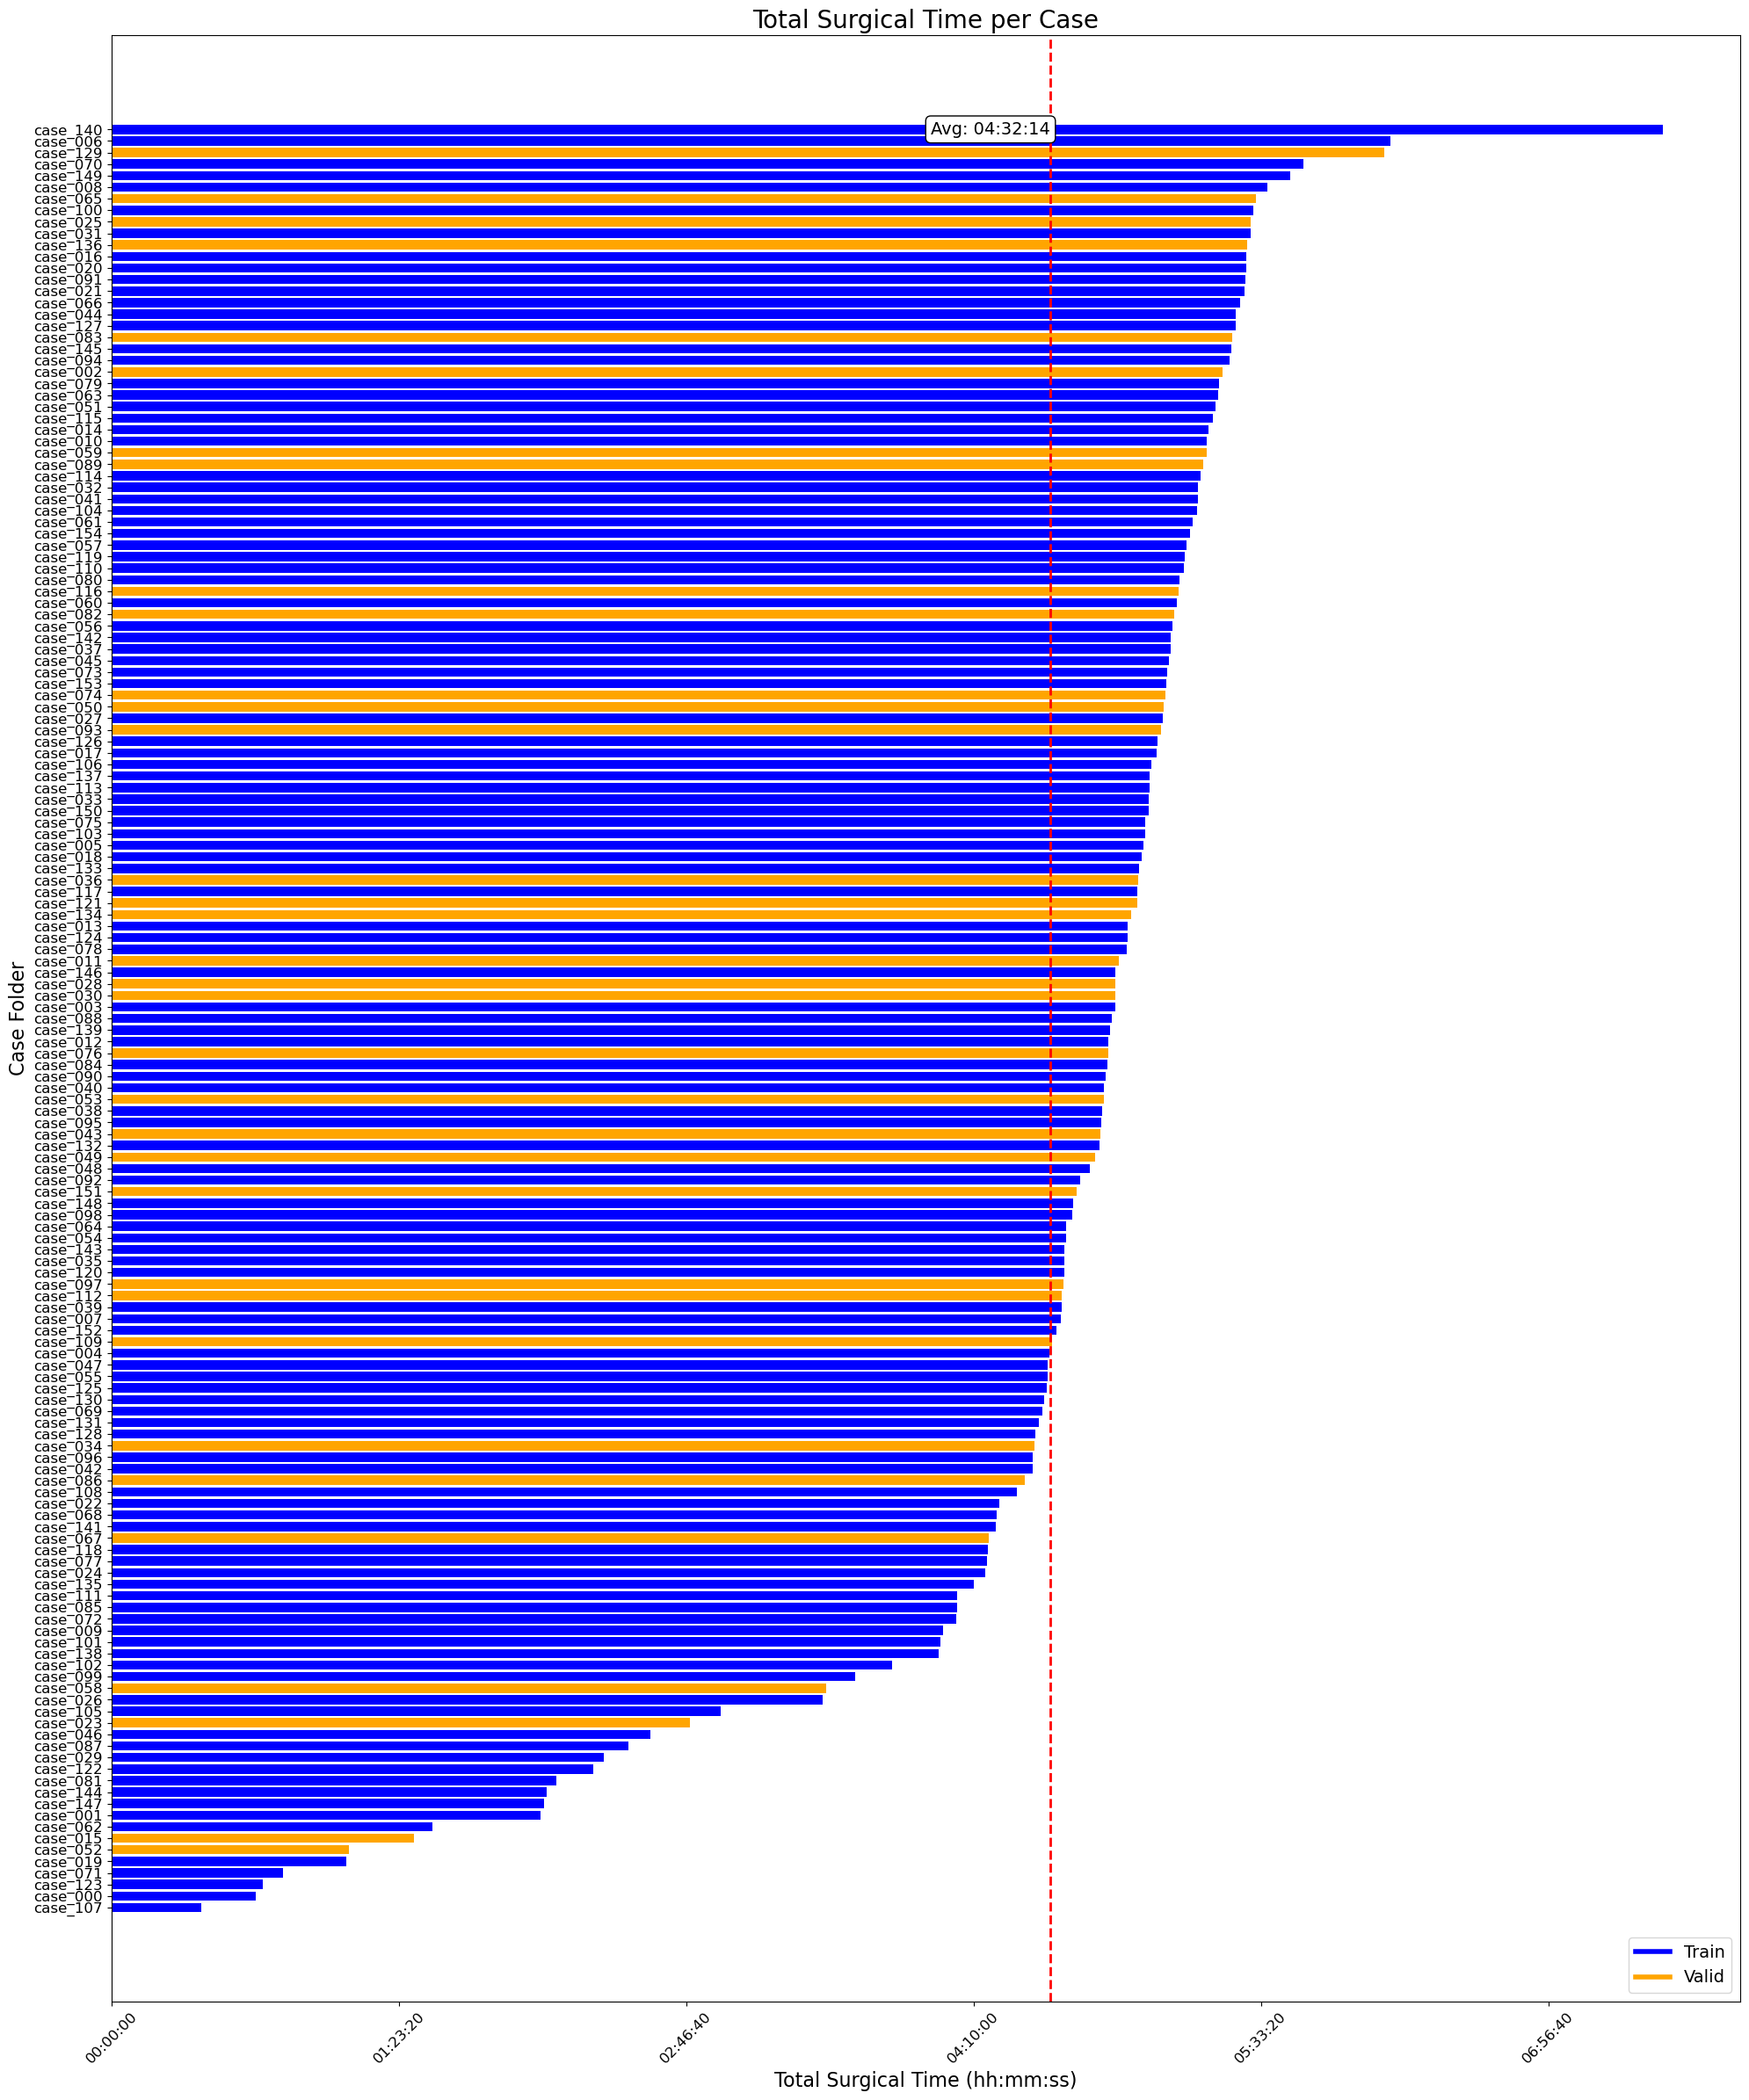

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from fastai.vision.all import *

def seconds_to_hms(x, pos=None):
    """Convert seconds to hh:mm:ss format."""
    hrs = int(x // 3600)
    mins = int((x % 3600) // 60)
    secs = int(x % 60)
    return f'{hrs:02}:{mins:02}:{secs:02}'

def compute_surgical_time(frames_info_path):
    # Load the frames_info.csv file
    frames_df = pd.read_csv(frames_info_path)

    # Create a dictionary to store the total surgical time for each case
    surgical_time = {}
    
    # Group the data by case and valid columns
    grouped = frames_df.groupby(['case_folder', 'valid'])

    # Iterate through each group and sum up the times
    for (case, is_valid), group in grouped:
        total_time = group['timestamp'].astype(float).max()
        surgical_time[case] = (total_time, is_valid)

    # Create a DataFrame for plotting
    surgical_time_df = pd.DataFrame.from_dict(surgical_time, orient='index', columns=['TotalTime', 'IsValid'])
    surgical_time_df = surgical_time_df.sort_values(by='TotalTime')

    # Plot the surgical times with different colors based on the train/validation split
    plt.figure(figsize=(20, 24))  # Increased height to improve label visibility
    
    # Define colors for train and validation sets
    colors = surgical_time_df['IsValid'].map({True: 'orange', False: 'blue'})
    
    # Plot the bars with gaps by setting 'height' parameter
    bars = plt.barh(surgical_time_df.index, surgical_time_df['TotalTime'], color=colors, height=0.8)

    # Add a line for the average surgical time
    avg_time = surgical_time_df['TotalTime'].mean()
    plt.axvline(avg_time, color='red', linestyle='--', linewidth=2)
    
    # Format the average time in hh:mm:ss
    avg_time_hms = seconds_to_hms(avg_time)
    
    # Annotate the average line with a white background for visibility
    plt.text(avg_time, len(surgical_time_df) - 1, f'Avg: {avg_time_hms}', 
             color='black', fontsize=14, va='center', ha='right',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    # Set labels and title with increased font size
    plt.xlabel('Total Surgical Time (hh:mm:ss)', fontsize=16)
    plt.ylabel('Case Folder', fontsize=16)
    plt.title('Total Surgical Time per Case', fontsize=20)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(seconds_to_hms))  # Apply the formatter
    plt.tight_layout()

    # Add a legend with increased font size
    plt.legend(handles=[plt.Line2D([0], [0], color='blue', lw=4, label='Train'),
                        plt.Line2D([0], [0], color='orange', lw=4, label='Valid')],
               loc='lower right', fontsize=14)

    # Show the plot
    plt.show()

# Example usage:
frames_info_path = '/home/exsdatalab/data/surgvu24/frames_info.csv'
compute_surgical_time(frames_info_path)

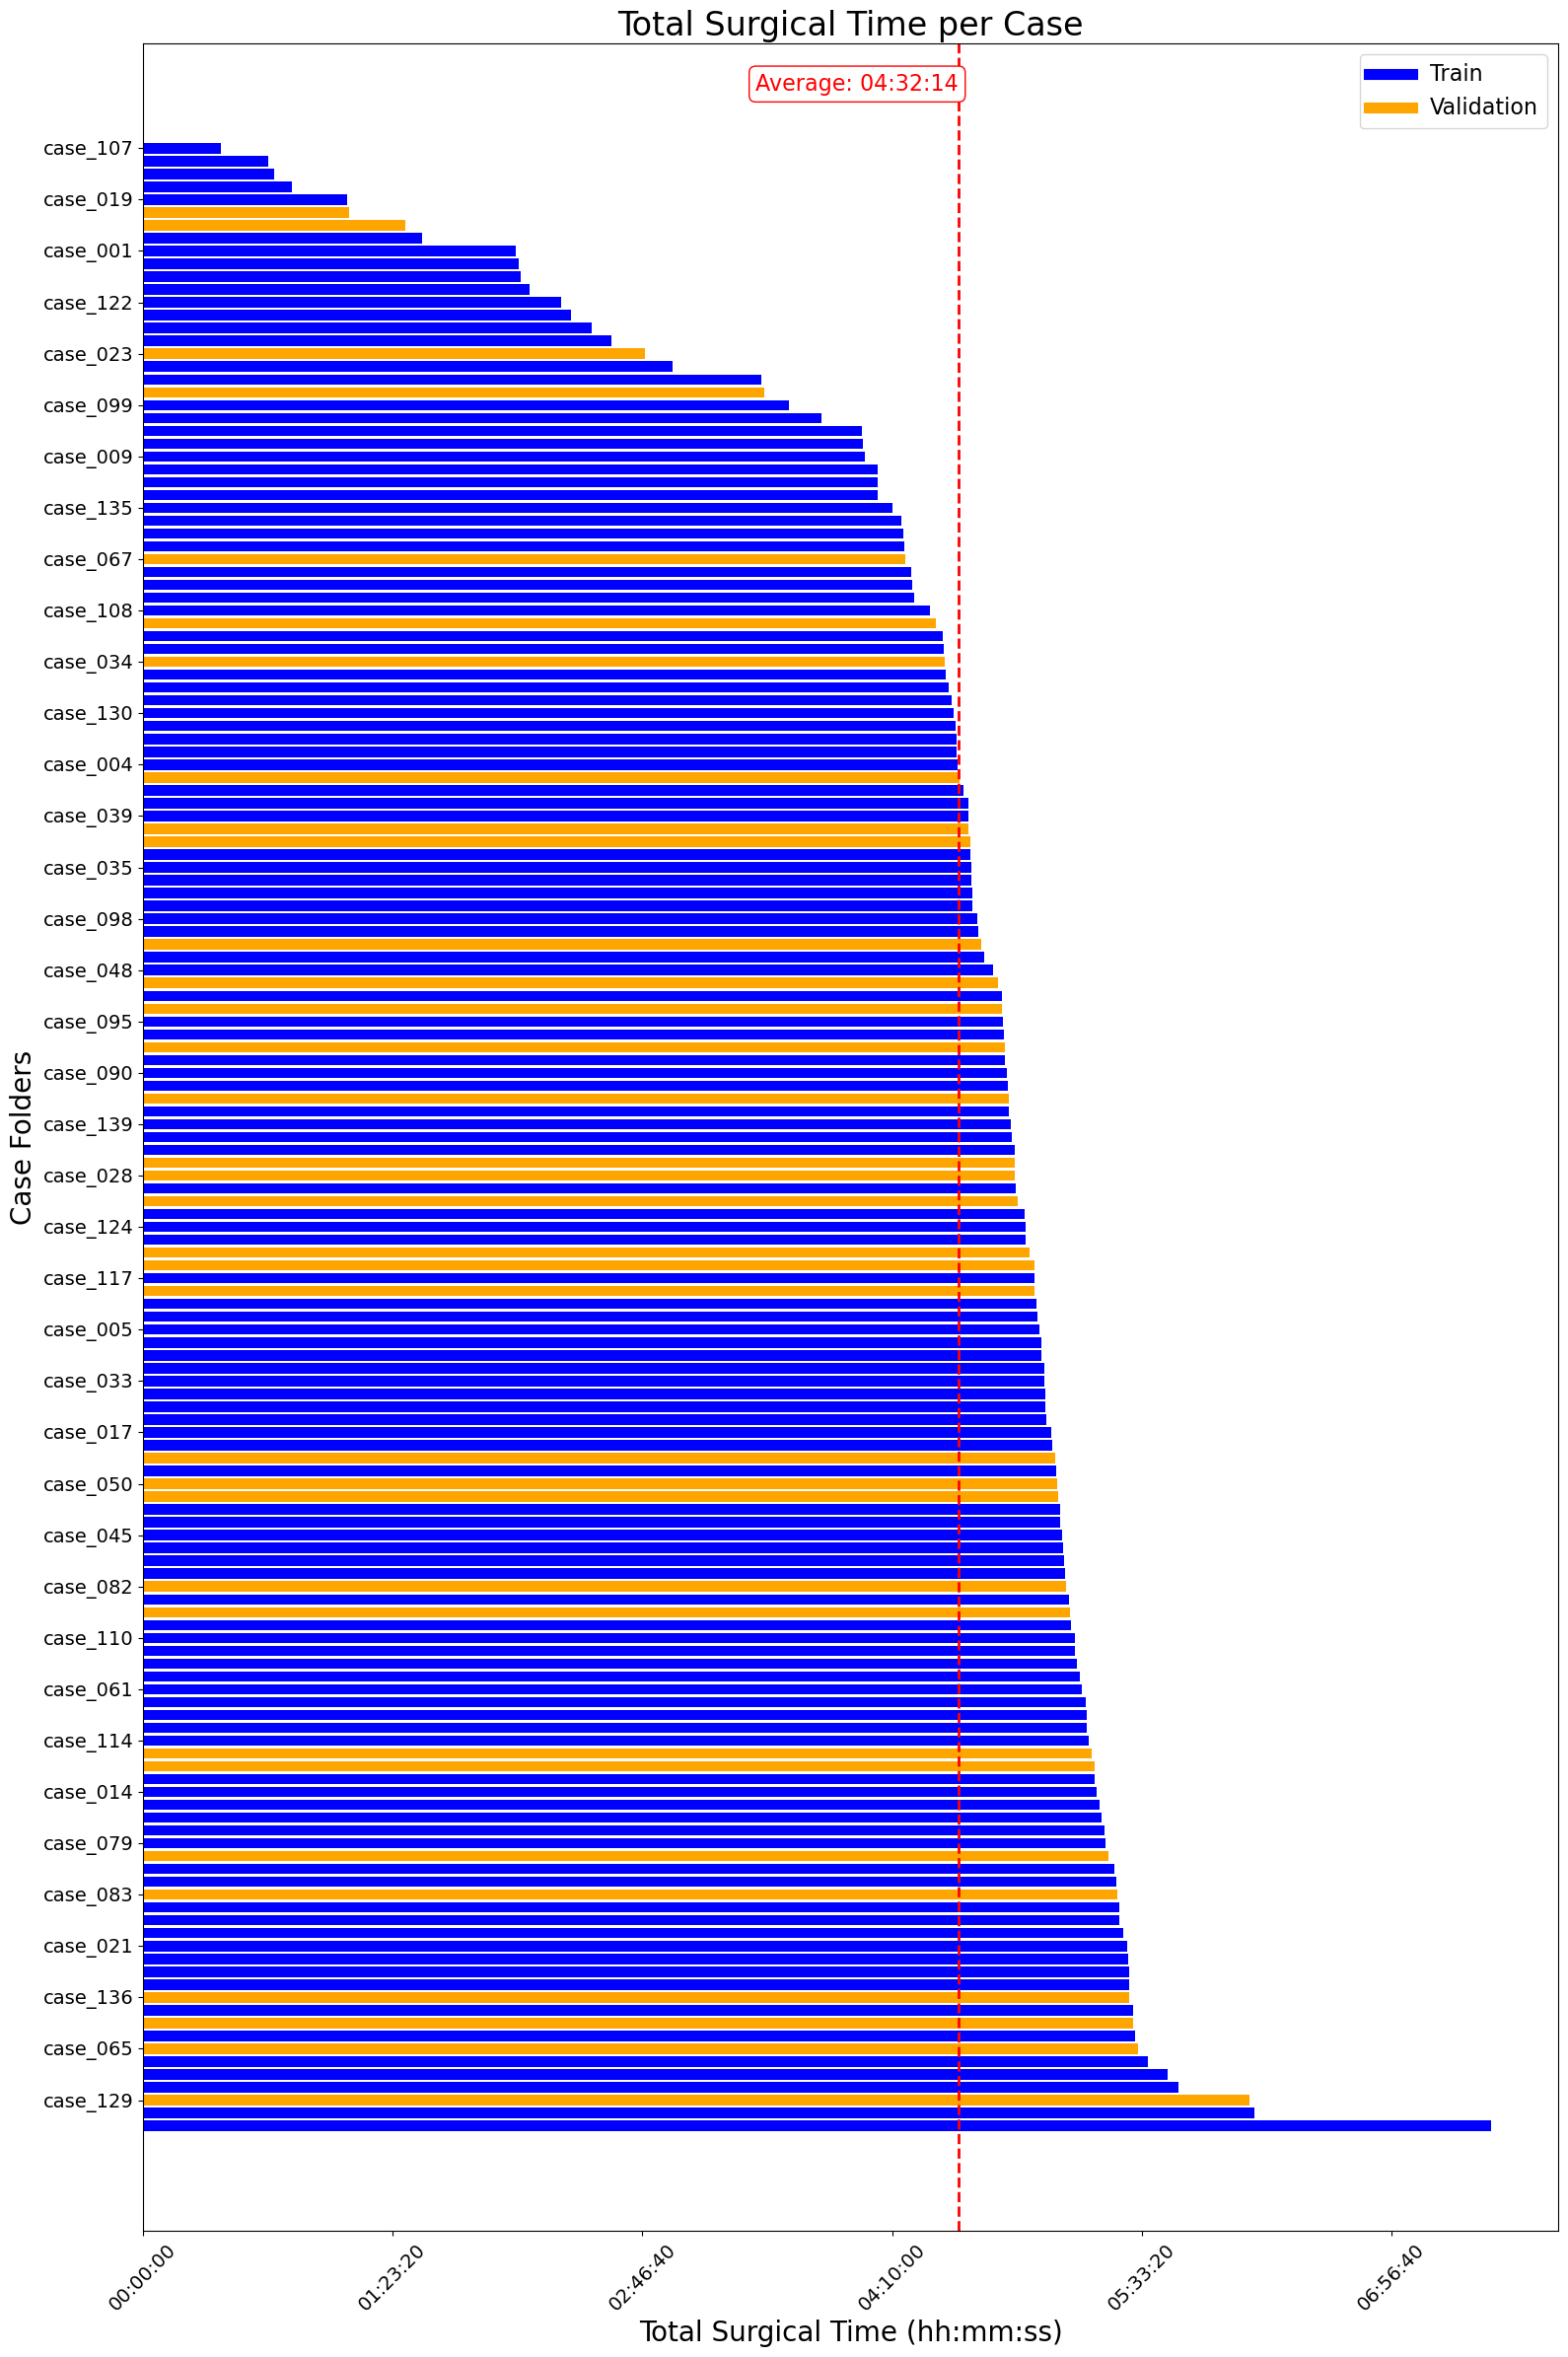

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

def seconds_to_hms(x, pos=None):
    """Convert seconds to hh:mm:ss format."""
    hrs = int(x // 3600)
    mins = int((x % 3600) // 60)
    secs = int(x % 60)
    return f'{hrs:02}:{mins:02}:{secs:02}'

def compute_surgical_time(frames_info_path):
    # Load the frames_info.csv file
    frames_df = pd.read_csv(frames_info_path)

    # Create a dictionary to store the total surgical time for each case
    surgical_time = {}
    
    # Group the data by case and valid columns
    grouped = frames_df.groupby(['case_folder', 'valid'])

    # Iterate through each group and get the maximum timestamp
    for (case, is_valid), group in grouped:
        total_time = group['timestamp'].astype(float).max()
        surgical_time[case] = (total_time, is_valid)

    # Create a DataFrame for plotting
    surgical_time_df = pd.DataFrame.from_dict(surgical_time, orient='index', columns=['TotalTime', 'IsValid'])
    surgical_time_df = surgical_time_df.sort_values(by='TotalTime')
    surgical_time_df.reset_index(inplace=True)
    surgical_time_df.rename(columns={'index': 'CaseFolder'}, inplace=True)
    
    # Prepare the figure
    fig, ax = plt.subplots(figsize=(16, 24))  # Adjusted width and height for better visibility

    # Define colors for train and validation sets
    colors = surgical_time_df['IsValid'].map({True: 'orange', False: 'blue'})

    # Plot the bars
    y_positions = np.arange(len(surgical_time_df))
    bar_height = 0.8
    bars = ax.barh(y_positions, surgical_time_df['TotalTime'], color=colors, height=bar_height)

    # Set y-axis labels to case folders at intervals to show more labels
    interval = 4  # Skip three labels and show one
    ax.set_yticks(y_positions[::interval])
    ax.set_yticklabels(surgical_time_df['CaseFolder'][::interval], fontsize=12)  # Adjusted font size
    
    # Invert y-axis so the longest times are at the top
    ax.invert_yaxis()

    # Add a line for the average surgical time
    avg_time = surgical_time_df['TotalTime'].mean()
    ax.axvline(avg_time, color='red', linestyle='--', linewidth=2)
    
    # Format the average time in hh:mm:ss
    avg_time_hms = seconds_to_hms(avg_time)
    
    # Annotate the average line
    ax.text(avg_time, -5, f'Average: {avg_time_hms}', 
            color='red', fontsize=16, va='center', ha='right',
            bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))

    # Set labels and title with increased font size
    ax.set_xlabel('Total Surgical Time (hh:mm:ss)', fontsize=20)
    ax.set_ylabel('Case Folders', fontsize=20)
    ax.set_title('Total Surgical Time per Case', fontsize=24)
    
    # Increase tick label sizes
    ax.tick_params(axis='x', labelrotation=45, labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.xaxis.set_major_formatter(FuncFormatter(seconds_to_hms))  # Apply the formatter

    # Add a legend with increased font size
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='blue', lw=8, label='Train'),
                       Line2D([0], [0], color='orange', lw=8, label='Validation')]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=16)

    # Adjust layout to fit everything
    plt.tight_layout()

    # Save the figure in high resolution
    plt.savefig('surgical_time_distribution.png', dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

# Example usage:
frames_info_path = '/home/exsdatalab/data/surgvu24/frames_info.csv'
compute_surgical_time(frames_info_path)

In [10]:
import pandas as pd
import os
from datetime import timedelta

def update_labels_with_tools(labels_df, root_directory):
    # Initialize new columns in the labels dataframe
    labels_df['usm1_tool_label'] = ""
    labels_df['usm2_tool_label'] = ""
    labels_df['usm3_tool_label'] = ""
    labels_df['usm4_tool_label'] = ""
    labels_df['install_case_time'] = ""
    labels_df['uninstall_case_time'] = ""

    # Cache to store loaded tools.csv files to avoid reloading
    tools_cache = {}

    # Iterate over each row in the labels dataframe
    for idx, row in labels_df.iterrows():
        case_folder = row['case_folder']
        timestamp_seconds = row['timestamp']

        # Convert the timestamp from seconds into a timedelta format
        current_timestamp = timedelta(seconds=timestamp_seconds)

        # Check if we have already loaded the tools.csv for this case folder
        if case_folder not in tools_cache:
            # Construct the path to the corresponding tools.csv file
            tools_path = os.path.join(root_directory, 'dataset', case_folder, 'tools.csv')
            if os.path.exists(tools_path):
                tools_cache[case_folder] = pd.read_csv(tools_path)
            else:
                tools_cache[case_folder] = None

        # Get the tools DataFrame for the current case folder
        tools_df = tools_cache[case_folder]
        
        if tools_df is not None:
            # Convert time columns to timedelta for accurate comparison
            tools_df['install_case_time'] = pd.to_timedelta(tools_df['install_case_time'])
            tools_df['uninstall_case_time'] = pd.to_timedelta(tools_df['uninstall_case_time'])

            # Filter tools.csv based on the timestamp range
            matching_tools = tools_df[
                (tools_df['install_case_time'] <= current_timestamp) &
                (tools_df['uninstall_case_time'] >= current_timestamp)
            ]
            
            # Extract install and uninstall times for the first matching row (for verification)
            if not matching_tools.empty:
                install_time = matching_tools.iloc[0]['install_case_time']
                uninstall_time = matching_tools.iloc[0]['uninstall_case_time']
                labels_df.at[idx, 'install_case_time'] = str(install_time)
                labels_df.at[idx, 'uninstall_case_time'] = str(uninstall_time)

            # Populate tool labels for usm1, usm2, usm3, usm4
            for usm in ['usm1', 'usm2', 'usm3', 'usm4']:
                relevant_tools = matching_tools[matching_tools['arm'] == usm.upper()]
                if not relevant_tools.empty:
                    # Convert all tool names to strings, replace NaNs with an empty string
                    tool_names = relevant_tools['groundtruth_toolname'].fillna('').astype(str).unique()
                    labels_df.at[idx, f'{usm}_tool_label'] = ','.join(tool_names)
                else:
                    # If no groundtruth match is found, use the commercial_toolname as a fallback
                    commercial_toolnames = matching_tools['commercial_toolname'].fillna('').astype(str).unique()
                    labels_df.at[idx, f'{usm}_tool_label'] = ','.join(commercial_toolnames)

    return labels_df

# Example usage:
# Load the labels.csv file
root_directory = '/home/exsdatalab/data/surgvu24/'
labels_df = pd.read_csv(os.path.join(root_directory, 'labels.csv'))

# Update the labels dataframe with tool labels
updated_labels_df = update_labels_with_tools(labels_df, root_directory)

# Save the updated labels.csv file
updated_labels_df.to_csv(os.path.join(root_directory, 'labels_updated.csv'), index=False)

In [11]:
updated_labels_df

,case_folder,video_name,filename,timestamp,task_label,valid,unique_labels_count,usm1_tool_label,usm2_tool_label,usm3_tool_label,usm4_tool_label,install_case_time,uninstall_case_time
0,case_000,case_000_video_part_001.mp4,case_000_video_part_001_t8.333333_f000002,8.333333,Other/Unannotated,False,2,,Unknown Instrument,Unknown Instrument,Unknown Instrument,0 days 00:00:00,0 days 00:18:05.799000
1,case_000,case_000_video_part_001.mp4,case_000_video_part_001_t25.000000_f000006,25.000000,Other/Unannotated,False,2,,Unknown Instrument,Unknown Instrument,Unknown Instrument,0 days 00:00:00,0 days 00:18:05.799000
2,case_000,case_000_video_part_001.mp4,case_000_video_part_001_t29.166667_f000007,29.166667,Other/Unannotated,False,2,,Unknown Instrument,Unknown Instrument,Unknown Instrument,0 days 00:00:00,0 days 00:18:05.799000
3,case_000,case_000_video_part_001.mp4,case_000_video_part_001_t99.416667_f000024,99.416667,Other/Unannotated,False,2,,Unknown Instrument,Unknown Instrument,Unknown Instrument,0 days 00:00:00,0 days 00:18:05.799000
4,case_000,case_000_video_part_001.mp4,case_000_video_part_001_t124.416667_f000030,124.416667,Other/Unannotated,False,2,,Unknown Instrument,Unknown Instrument,Unknown Instrument,0 days 00:00:00,0 days 00:18:05.799000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
279147,case_154,case_154_video_part_002.mp4,case_154_video_part_002_t1888.833333_f000457,1888.833333,Other/Unannotated,False,7,needle driver,nan(camera in),monopolar curved scissors,prograsp forceps,0 days 00:24:33.583000,0 days 00:32:37.883000
279148,case_154,case_154_video_part_002.mp4,case_154_video_part_002_t1926.333333_f000466,1926.333333,Other/Unannotated,False,7,needle driver,nan(camera in),monopolar curved scissors,prograsp forceps,0 days 00:24:33.583000,0 days 00:32:37.883000
279149,case_154,case_154_video_part_002.mp4,case_154_video_part_002_t1930.500000_f000467,1930.500000,Other/Unannotated,False,7,needle driver,nan(camera in),monopolar curved scissors,prograsp forceps,0 days 00:24:33.583000,0 days 00:32:37.883000
279150,case_154,case_154_video_part_002.mp4,case_154_video_part_002_t1943.000000_f000470,1943.000000,Other/Unannotated,False,7,needle driver,nan(camera in),monopolar curved scissors,prograsp forceps,0 days 00:24:33.583000,0 days 00:32:37.883000


In [12]:
def count_single_tool_rows(updated_labels_df):
    # Create a function to count tools in each column
    def count_tools(tool_label):
        if pd.isna(tool_label) or tool_label == '':
            return 0
        return len(tool_label.split(','))

    # Apply the function to each robotic arm column and add the count as a new column
    updated_labels_df['usm1_tool_count'] = updated_labels_df['usm1_tool_label'].apply(count_tools)
    updated_labels_df['usm2_tool_count'] = updated_labels_df['usm2_tool_label'].apply(count_tools)
    updated_labels_df['usm3_tool_count'] = updated_labels_df['usm3_tool_label'].apply(count_tools)
    updated_labels_df['usm4_tool_count'] = updated_labels_df['usm4_tool_label'].apply(count_tools)

    # Filter rows where each robotic arm has exactly one tool
    single_tool_rows = updated_labels_df[
        (updated_labels_df['usm1_tool_count'] == 1) &
        (updated_labels_df['usm2_tool_count'] == 1) &
        (updated_labels_df['usm3_tool_count'] == 1) &
        (updated_labels_df['usm4_tool_count'] == 1)
    ]

    # Return the count of rows with exactly one tool for each arm
    single_tool_count = len(single_tool_rows)
    return single_tool_count, single_tool_rows

# Example usage:
# Assuming `updated_labels_df` is the DataFrame with the updated labels and tool counts
single_tool_count, single_tool_rows = count_single_tool_rows(updated_labels_df)

print(f"Number of rows with exactly one tool for each arm: {single_tool_count}")

Number of rows with exactly one tool for each arm: 163475


In [17]:
import pandas as pd

def filter_single_tool_rows(df):
    # Drop rows with NaN or null values in any of the usm columns
    df = df.dropna(subset=['usm1_tool_label', 'usm2_tool_label', 'usm3_tool_label', 'usm4_tool_label']).copy()

    # Count the number of tools in each usm column
    df.loc[:, 'usm1_tool_count'] = df['usm1_tool_label'].apply(lambda x: len(str(x).split(',')))
    df.loc[:, 'usm2_tool_count'] = df['usm2_tool_label'].apply(lambda x: len(str(x).split(',')))
    df.loc[:, 'usm3_tool_count'] = df['usm3_tool_label'].apply(lambda x: len(str(x).split(',')))
    df.loc[:, 'usm4_tool_count'] = df['usm4_tool_label'].apply(lambda x: len(str(x).split(',')))

    # Filter rows where each usm column has exactly one tool deployed
    filtered_df = df[
        (df['usm1_tool_count'] == 1) &
        (df['usm2_tool_count'] == 1) &
        (df['usm3_tool_count'] == 1) &
        (df['usm4_tool_count'] == 1)
    ].copy()

    # Drop the tool count columns
    filtered_df = filtered_df.drop(columns=['usm1_tool_count', 'usm2_tool_count', 'usm3_tool_count', 'usm4_tool_count'])
    
    return filtered_df

# Load the updated labels CSV file
root_directory = '/home/exsdatalab/data/surgvu24/'
updated_labels_df = pd.read_csv(root_directory + 'labels_updated.csv')

# Filter the DataFrame to keep only rows with one tool per arm and no null values
filtered_labels_df = filter_single_tool_rows(updated_labels_df)

# Save the filtered DataFrame to a new CSV file
filtered_labels_df.to_csv(root_directory + 'labels_updated2.csv', index=False)

In [18]:
filtered_labels_df.head()

,case_folder,video_name,filename,timestamp,task_label,valid,unique_labels_count,usm1_tool_label,usm2_tool_label,usm3_tool_label,usm4_tool_label,install_case_time,uninstall_case_time
61,case_000,case_000_video_part_001.mp4,case_000_video_part_001_t1471.700000_f000354,1471.700000,Other/Unannotated,False,2,30° Endoscope,30° Endoscope,nan(camera in),30° Endoscope,0 days 00:23:03.499000,0 days 00:41:58
62,case_000,case_000_video_part_001.mp4,case_000_video_part_001_t1475.866667_f000355,1475.866667,Other/Unannotated,False,2,30° Endoscope,30° Endoscope,nan(camera in),30° Endoscope,0 days 00:23:03.499000,0 days 00:41:58
63,case_000,case_000_video_part_001.mp4,case_000_video_part_001_t1480.033333_f000356,1480.033333,Other/Unannotated,False,2,30° Endoscope,30° Endoscope,nan(camera in),30° Endoscope,0 days 00:23:03.499000,0 days 00:41:58
64,case_000,case_000_video_part_001.mp4,case_000_video_part_001_t1488.366667_f000358,1488.366667,Other/Unannotated,False,2,30° Endoscope,30° Endoscope,nan(camera in),30° Endoscope,0 days 00:23:03.499000,0 days 00:41:58
65,case_000,case_000_video_part_001.mp4,case_000_video_part_001_t1538.366667_f000370,1538.366667,Other/Unannotated,False,2,prograsp forceps,force bipolar,nan(camera in),permanent cautery hook/spatula,0 days 00:23:03.499000,0 days 00:41:58


In [15]:
filtered_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188548 entries, 0 to 279150
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   case_folder          188548 non-null  object 
 1   video_name           188548 non-null  object 
 2   filename             188548 non-null  object 
 3   timestamp            188548 non-null  float64
 4   task_label           188548 non-null  object 
 5   valid                188548 non-null  bool   
 6   unique_labels_count  188548 non-null  int64  
 7   usm1_tool_label      163746 non-null  object 
 8   usm2_tool_label      165502 non-null  object 
 9   usm3_tool_label      165489 non-null  object 
 10  usm4_tool_label      165251 non-null  object 
 11  install_case_time    165518 non-null  object 
 12  uninstall_case_time  165518 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(10)
memory usage: 18.9+ MB


In [20]:
frames_df = filtered_labels_df

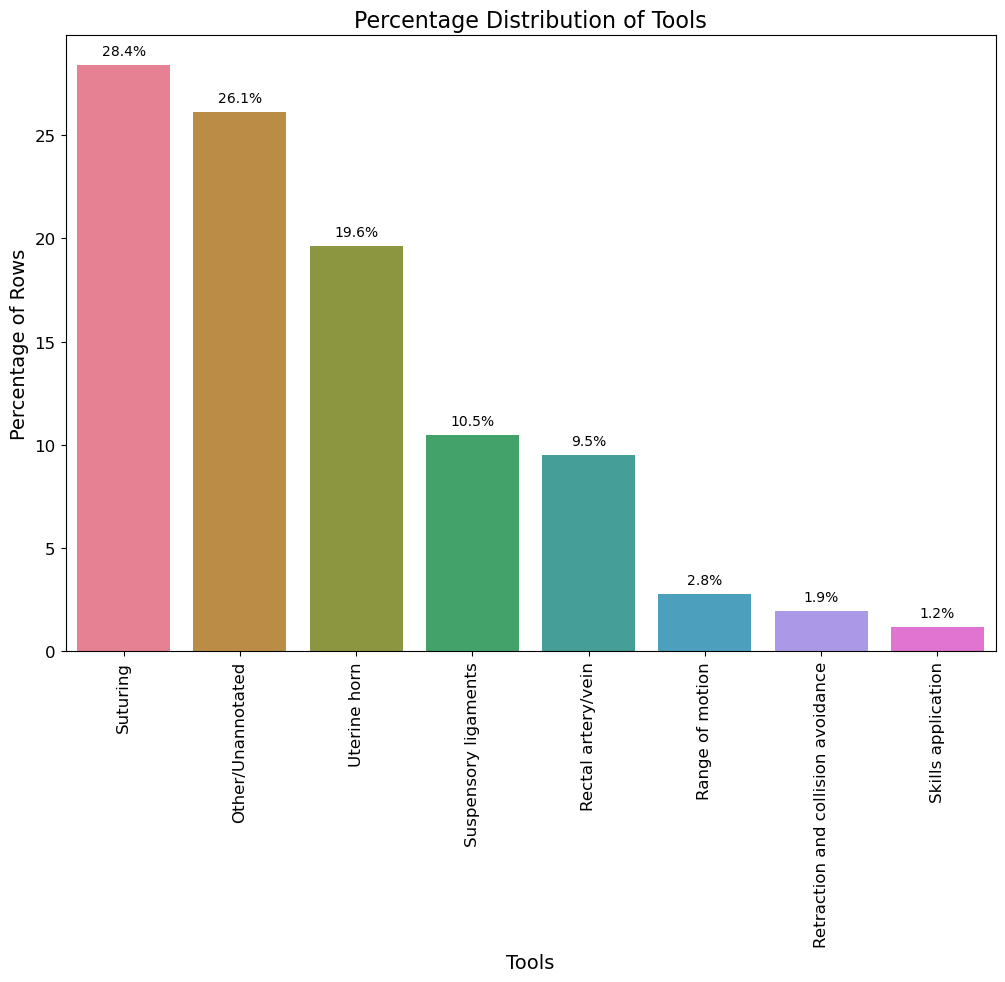

In [28]:
# Count the occurrences of each label
label_counts = frames_df['task_label'].value_counts()

# Convert counts to percentages
label_percentages = (label_counts / label_counts.sum()) * 100

# Create a bar plot
plt.figure(figsize=(12, 8))
colors = sns.color_palette("husl", len(label_percentages))  # Different colors for each bar

bar_plot = sns.barplot(x=label_percentages.index, y=label_percentages.values, palette=colors, hue=label_percentages.index, dodge=False, legend=False)
bar_plot.bar_width = 0.1

# Add percentage labels at the top of each bar
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height():.1f}%', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='center', 
                      xytext=(0, 10), 
                      textcoords='offset points')

plt.xlabel('Tools', fontsize=14)
plt.ylabel('Percentage of Rows', fontsize=14)
plt.title('Percentage Distribution of Tools', fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [29]:
label_counts

task_label
Suturing                              46434
Other/Unannotated                     42660
Uterine horn                          32068
Suspensory ligaments                  17098
Rectal artery/vein                    15559
Range of motion                        4530
Retraction and collision avoidance     3180
Skills application                     1946
Name: count, dtype: int64